In [6]:
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parsing_utils import *
from utils.utils import *


"""
Plots we want:
    - more plans being explored in each template when prioritizing
    - final qerr on the worst / best queries
        - hypothesis: worst jerr queries, prioritization will actually improve qerr
    - plot evolution of qerr vs jerr side by side for some queries
    - is each ideal plan in the explored plans at least once?
"""
RES_DIR = "./flow_results/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
df = get_all_training_df(RES_DIR)

In [182]:
df.keys()

Index(['epoch', 'loss_type', 'loss', 'summary_type', 'template', 'num_tables',
       'num_samples', 'samples_type', 'alg', 'hls', 'exp_name', 'lr',
       'clip_gradient', 'loss_func', 'priority', 'normalize_flow_loss'],
      dtype='object')

In [184]:
df = df[df["template"] == "all"]
df = df[df["num_tables"] == "all"]

cols = ["alg", "loss_func", "lr"]
df['alg_name'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
HUE_COLORS = {'mscn_qloss_0.001':'blue', \
              'mscn_flow_loss2_0.001':'red', \
              'mscn_flow_loss2_0.0001':'orange'}
print(set(df["alg_name"]))

{'mscn_qloss_0.001', 'mscn_flow_loss2_0.001', 'mscn_flow_loss2_0.0001'}


# Gradients

* We consider three algorithms: 
    * mscn_flow_loss2_0.001: MSCN model trained using flow loss, learning rate: 0.001
    * mscn_flow_loss2_0.0001: MSCN model trained using flow loss, learning rate: 0.01
    * mscn_qloss_0.001: MSCN model trained using qloss

* Because the scales of all gradients are different, we plot them separately.
* Most interesting are the first two plots: flow_loss with the original learning rate we had (0.001) and slower learning rate (0.0001).
* All the gradients are clipped at +/- 20.

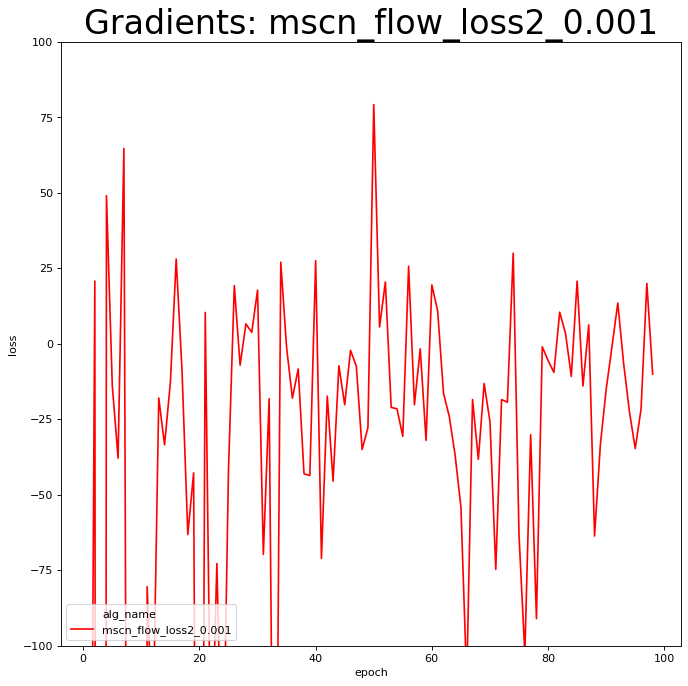

<Figure size 432x288 with 0 Axes>

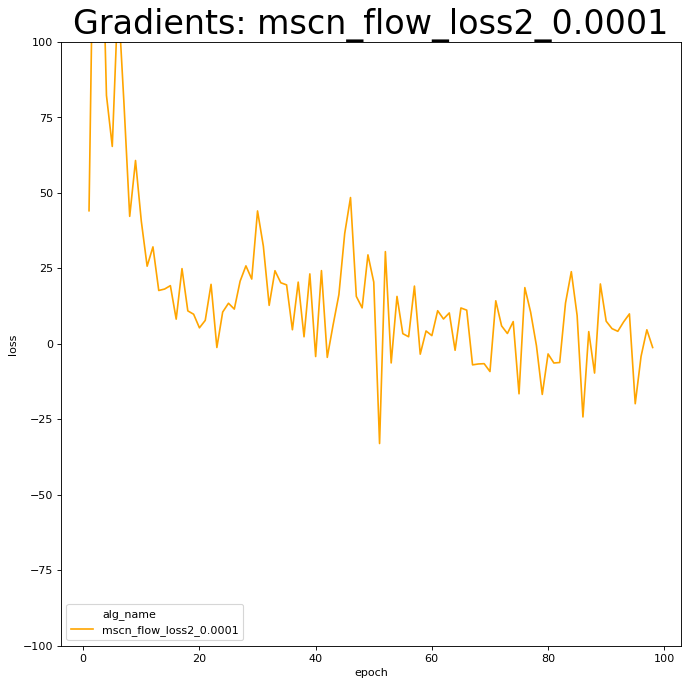

<Figure size 432x288 with 0 Axes>

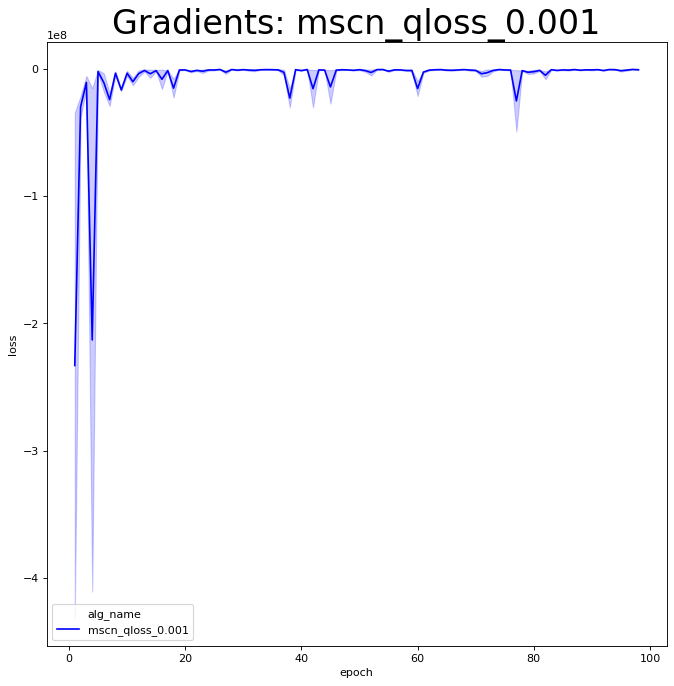

<Figure size 432x288 with 0 Axes>

In [196]:
def plot_grad(df, loss_func, lr, ylim):
    fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    cur_df = df[df["loss_func"] == loss_func]
    cur_df = cur_df[cur_df["lr"] == lr]
    sns.lineplot(x="epoch", y="loss", data=cur_df, hue="alg_name", palette=HUE_COLORS)
    plt.ylim(ylim)
    alg_name = list(set(cur_df["alg_name"]))[0]
    plt.title("Gradients: " + alg_name, fontsize=30)
    #plt.yscale("log")
    plt.show()
    plt.clf()

# Gradients
grad_df = df[df["loss_type"] == "gradients"]

plot_grad(grad_df, "flow_loss2", 0.001, (-100,100))
plot_grad(grad_df, "flow_loss2", 0.0001, (-100, 100))
plot_grad(grad_df, "qloss", 0.001, (None, None))


In [191]:
title_fmt = "{}-{}"
def plot_loss(df, loss_type, samples_type, yscale):

    fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    title = title_fmt.format(loss_type, samples_type)
    plt.title(title, fontsize=50)
    cur_df = df[df["samples_type"] == samples_type]
    cur_df = cur_df[cur_df["loss_type"] == loss_type]
    
    scale_df = df[df["epoch"] == 4]
    scale_df = scale_df[scale_df["loss_type"] == loss_type]
    maxy = max(scale_df["loss"])
    miny = min(cur_df["loss"])

    sns.lineplot(x="epoch", y="loss", hue="alg_name", data=cur_df, palette=HUE_COLORS, ci=None)
    #plt.ylim(ylim)
    plt.ylim((miny,maxy))
    plt.yscale(yscale)
    plt.rc('legend', fontsize=10, loc="lower left")    # legend fontsize
    plt.show()


# Loss Results

* Train - Test results over all the losses 
* Since these are results on just 10% of the data, train - test generalization results may not be very representative


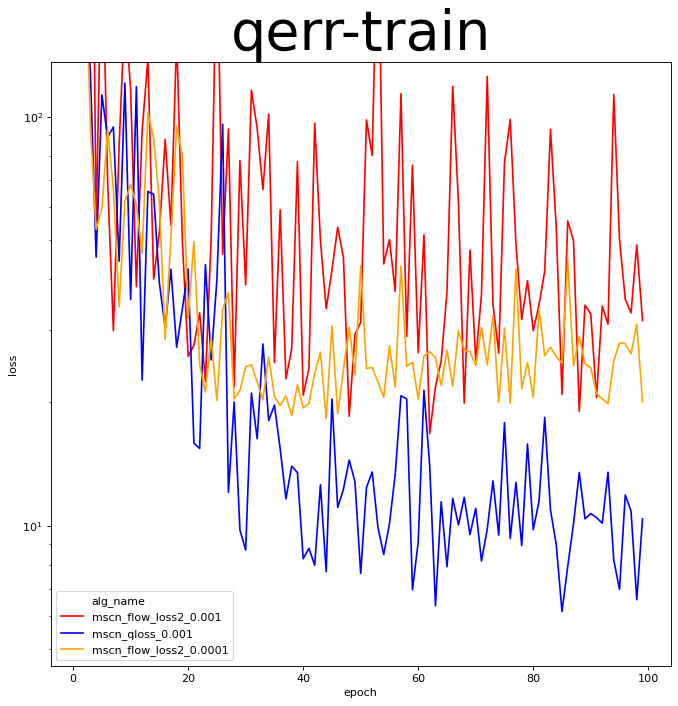

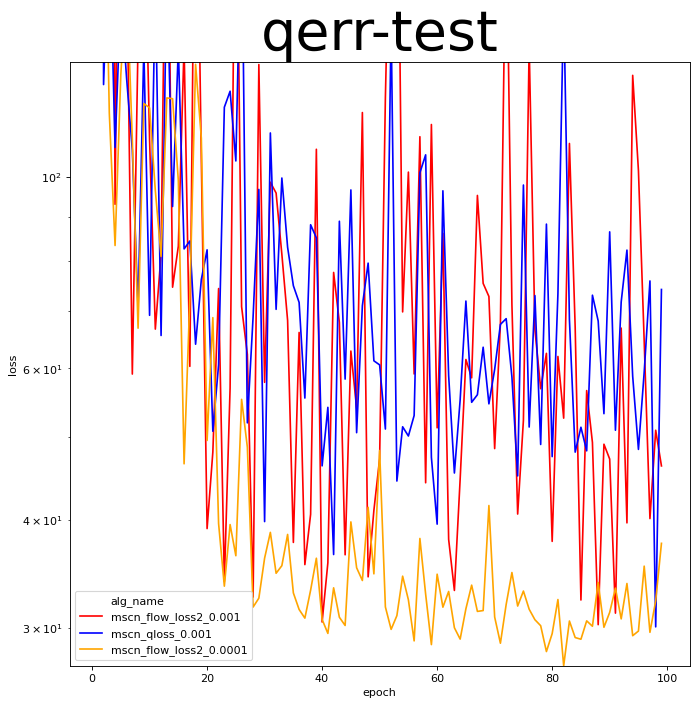

In [192]:
plot_loss(df, "qerr", "train", "log")
plot_loss(df, "qerr", "test", "log")

# Flow Error

## Flow_Loss - Optimal_Flow_loss

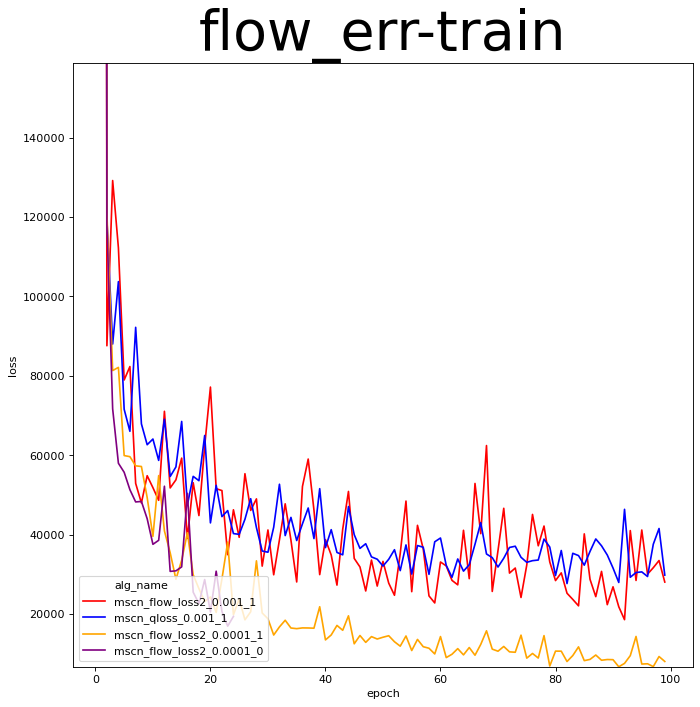

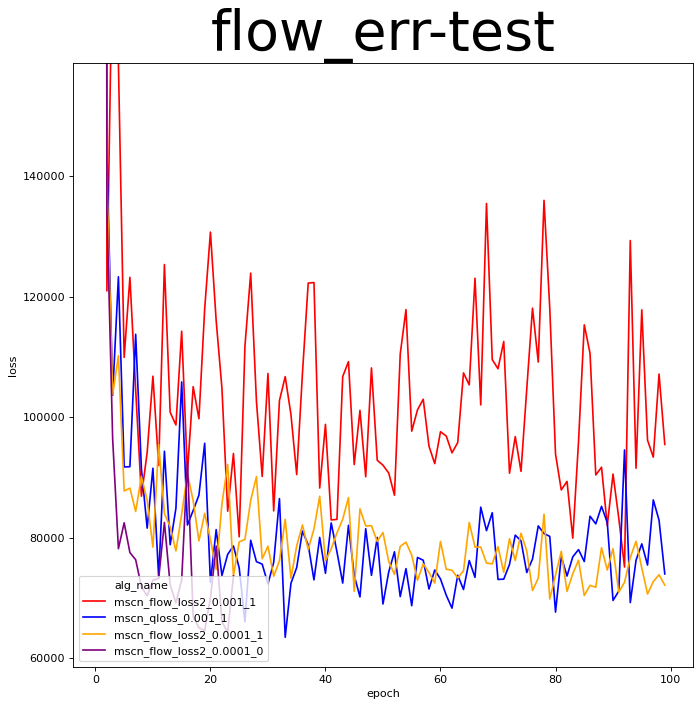

In [179]:
plot_loss(df, "flow_err", "train", "linear")
plot_loss(df, "flow_err", "test", "linear")

# Flow Ratio

## Flow_Loss / Optimal_Flow_loss

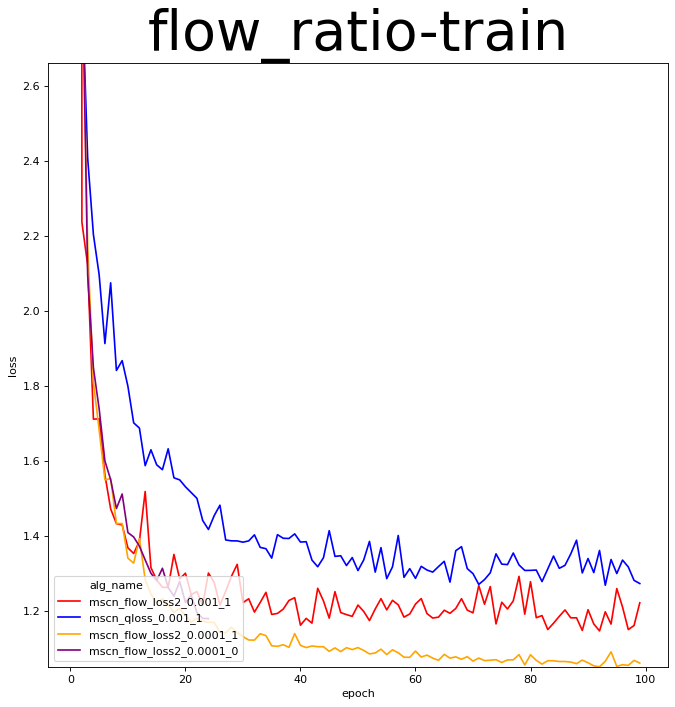

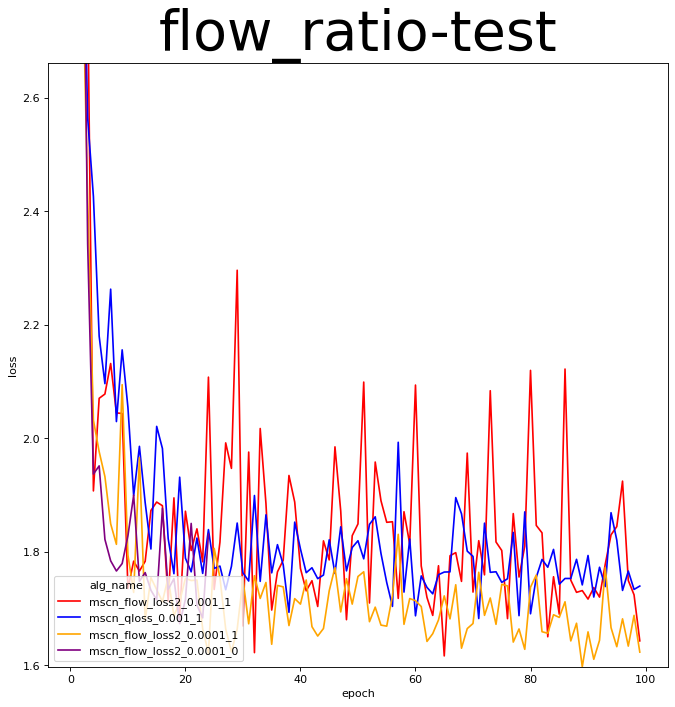

In [180]:
plot_loss(df, "flow_ratio", "train", "linear")
plot_loss(df, "flow_ratio", "test", "linear")

In [164]:
set(df["loss_type"])

{'flow_err',
 'flow_ratio',
 'gradients',
 'jerr',
 'mm1_plan_err',
 'mm1_plan_ratio',
 'qerr'}

# MM1 Cost Model: Plan Error

## Simple Cost model that we used to define flow loss

## Plan Cost  - Optimal Plan Cost

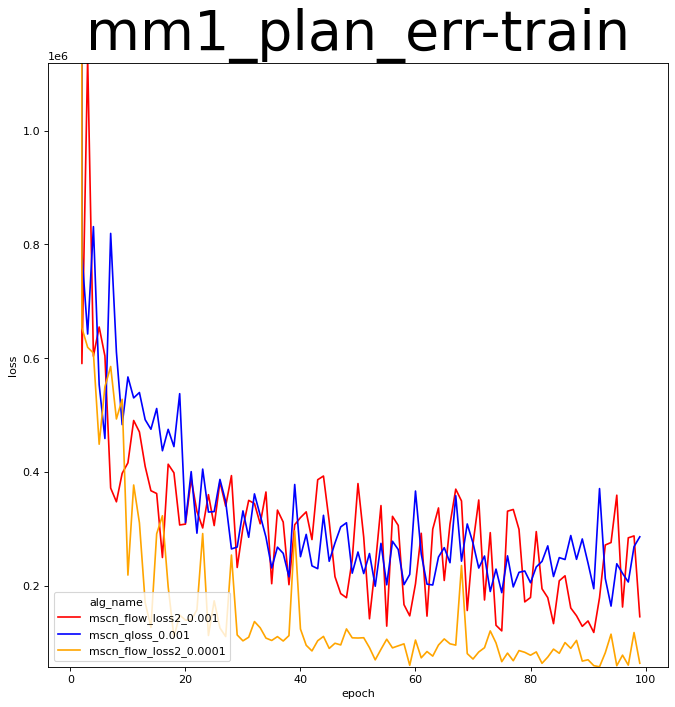

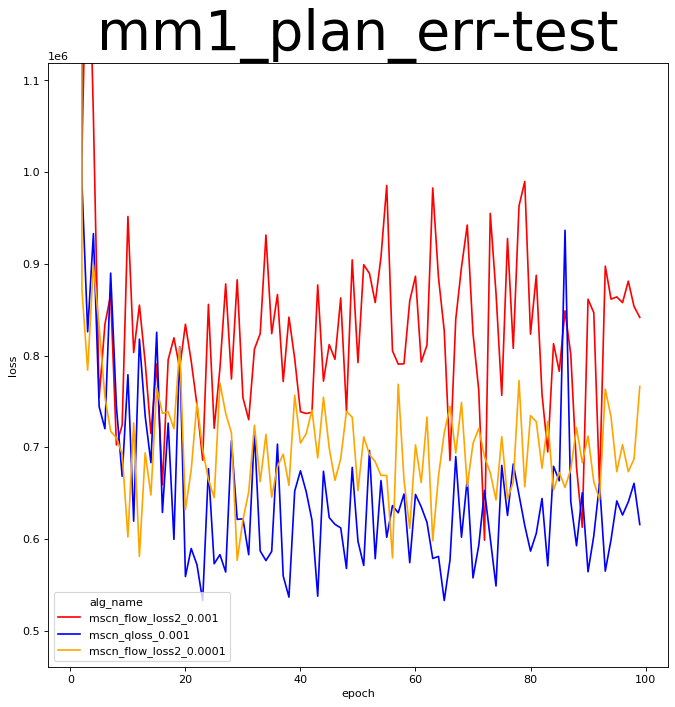

In [166]:
plot_loss(df, "mm1_plan_err", "train", "linear")
plot_loss(df, "mm1_plan_err", "test", "linear")

# MM1 Cost Model: Plan Ratio

## Simple Cost model that we used to define flow loss

## Plan Cost  / Optimal Plan Cost

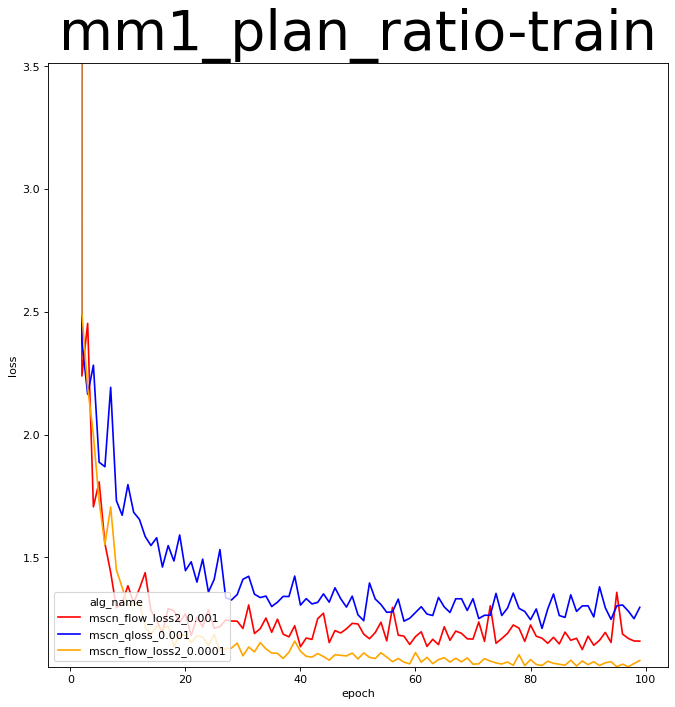

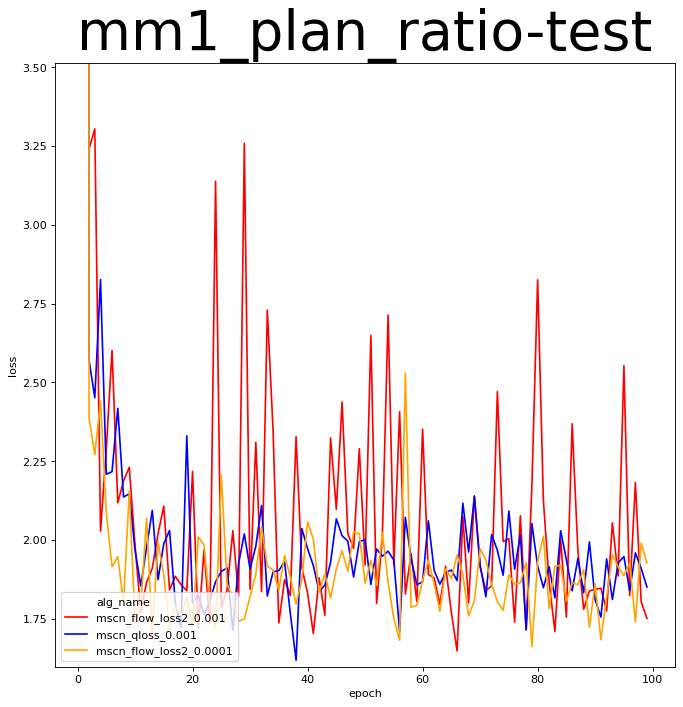

In [167]:
plot_loss(df, "mm1_plan_ratio", "train", "linear")
plot_loss(df, "mm1_plan_ratio", "test", "linear")